In [57]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm  # Import tqdm for progress bar
import seaborn as sns
import random

In [58]:
def set_seed(seed=42):
    torch.manual_seed(seed)             # CPU随机性
    torch.cuda.manual_seed(seed)        # GPU随机性（单卡）
    torch.cuda.manual_seed_all(seed)    # GPU随机性（多卡）
    np.random.seed(seed)                # NumPy随机性
    random.seed(seed)                   # Python随机性
    torch.backends.cudnn.deterministic = True  # 固定卷积算法
    torch.backends.cudnn.benchmark = False     # 禁止自动寻找最优算法（为了可重复性）

In [ ]:
set_seed(40)
folderpath_first = '/home/yuqster/files/research/dataset/autostop1'

data_list_first = []
labels_first = []

material = ['air','water']

In [60]:
file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_first) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_first}/{path}')
        trans = data.values
        data_list_first.append(trans)
        labels_first.append(i)

In [61]:

data_list = data_list_first
labels = labels_first

X = np.array(data_list).squeeze()
y = np.array(labels).reshape(-1, 1)
print(X.shape)
print(y.shape)

(30965, 4096)
(30965, 1)


In [62]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [63]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=44)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


scaler = MinMaxScaler(feature_range=(0, len(material)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)



print(y_train)
print(X_train.shape)
print(y_train.shape)


[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]
(27868, 4096)
(27868, 1)


In [64]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 384)
        self.fc2 = nn.Linear(384, 64)
        self.fc3 = nn.Linear(64, 6)
        self.fc4 = nn.Linear(6, 2)




    def forward(self, i):
        h1 = torch.relu(self.fc1(i))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        o4 = self.fc4(h3)
        return o4


In [65]:
model = ANN_Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


In [66]:
# 5. 训练模型
num_epochs = 5000
train_losses = []

# Convert y_train_tensor to the correct type
y_train_tensor = y_train_tensor.squeeze().long() # Remove extra dimension and convert to long

pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # 更新进度条，显示当前 loss
    pbar.set_postfix(loss=loss.item())

Training: 100%|██████████| 5000/5000 [01:02<00:00, 79.56it/s, loss=0.00037] 


In [67]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9996771068776235
Accuracy_train: 1.0
Confusion Matrix:
[[1299    0]
 [   1 1797]]


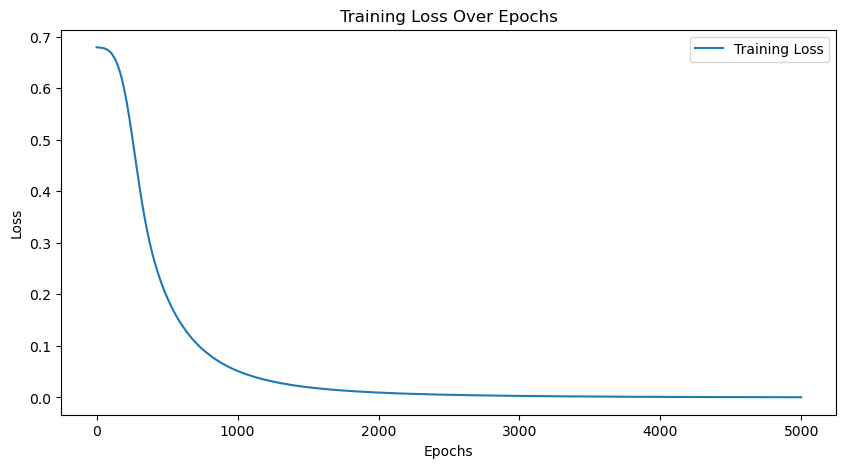

In [68]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

# 7. 可视化训练损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

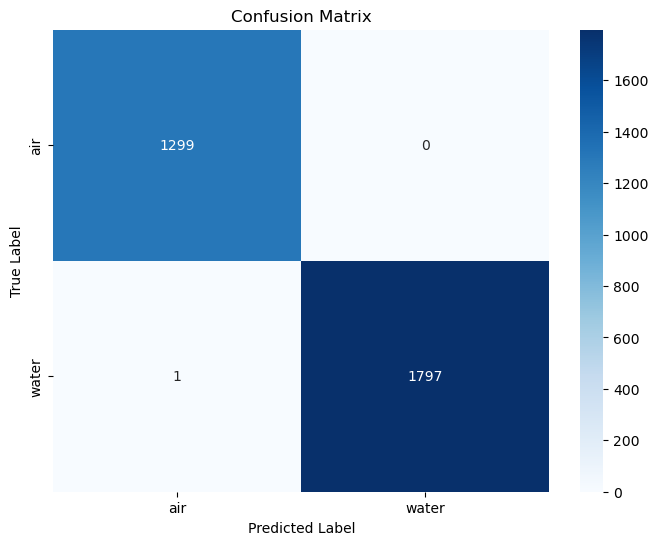

Accuracy: 0.9996771068776235
              precision    recall  f1-score   support

         air       1.00      1.00      1.00      1299
       water       1.00      1.00      1.00      1798

    accuracy                           1.00      3097
   macro avg       1.00      1.00      1.00      3097
weighted avg       1.00      1.00      1.00      3097



In [69]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=material,
            yticklabels=material)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=material, labels=range(len(material)))
print("Accuracy:", accuracy)
print(report)

In [70]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy()
    return hook

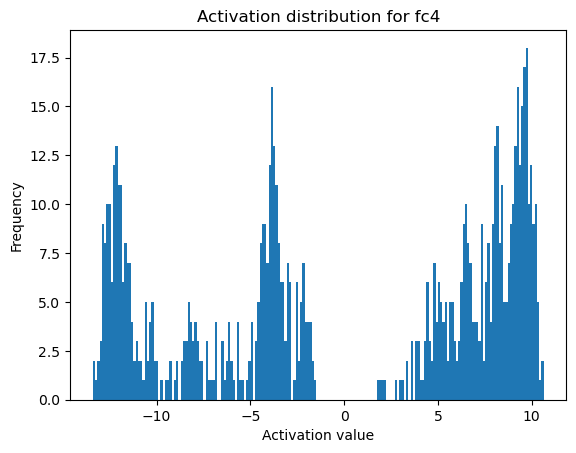

In [73]:
model.fc4.register_forward_hook(get_activation('fc4'))
# 前向传播一批数据
_ = model(torch.tensor(X_train[:400], dtype=torch.float32).to(device))

# 绘制 fc1 层的激活值直方图
plt.hist(activations['fc4'].flatten(), bins=200)
plt.title("Activation distribution for fc4")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

In [75]:
# Remove all forward hooks from fc4 to avoid TorchScript hook errors
model.fc4._forward_hooks.clear()
# 仍使用上面的 MyModel 实例
scripted_model = torch.jit.script(model)


In [77]:
save_dir = '/home/yuqster/files/research/model'
model_path = os.path.join(save_dir, 'scripted_model.pt')
torch.jit.save(scripted_model, model_path)
print(f"TorchScript 模型已保存到 {model_path}")


TorchScript 模型已保存到 /home/yuqster/files/research/model/scripted_model.pt
